In [0]:
import matplotlib.pyplot as plt

In [0]:

import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

class VBGP_PS:
  def __init__(self, num_support_points, dim, device="cuda" ):
    self.M = num_support_points
    self.D = dim
    self.device = device

    self.theta0 = torch.zeros(1, requires_grad=True )
    self.theta1 = torch.zeros(1, requires_grad=True )
    self.theta2 = torch.rand(1, requires_grad=True )

    self.support_points = torch.tensor( (np.random.rand(self.M, self.D)-0.5)*10, requires_grad=True  )


  def k(self, xi, xj):
    return torch.exp(self.theta0) * torch.exp(-0.5 * torch.exp(self.theta1) * torch.sum((xi - xj) * (xi - xj), 2)) 
    #return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 
  
  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.D).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.D).repeat(len(xi), 1, 1)
    return self.k(a,b).float()

  def learn(self, xt, yt, r ):
    self.xt = torch.Tensor(xt)
    self.yt = torch.Tensor(yt)
    N = len(xt)

    # to gpu
    self.xt.to(self.device)
    self.yt.to(self.device)
    self.theta0.to(self.device)
    self.theta1.to(self.device)
    self.support_points.to(self.device)

    #optimizer = torch.optim.Adam( [self.support_points], lr=0.01)
    optimizer = torch.optim.Adam( [self.support_points, self.theta0, self.theta1, self.theta2], lr=0.1)

    r = torch.Tensor(r)
    self.r = r
    self.W = torch.diag( torch.sqrt(r) )

    for i in range(1000):
      # カーネル行列を定義
      self.Kmm = self.cov( self.support_points, self.support_points )
      self.Kmm_inv = torch.inverse( self.Kmm+torch.eye(self.M, self.M)*0.001 )
      self.Knm = self.cov( self.xt, self.support_points )      

      self.Kmn = torch.t( self.Knm )
      self.Knn = self.cov( self.xt, self.xt )
      self.Knn_ = torch.mm( torch.mm(self.Knm, self.Kmm_inv), self.Kmn )

      self.sig2 = torch.exp( self.theta2 ) + 0.01


      # 報酬で重み付けした行列
      self.WKnm = torch.mm( self.W, self.Knm )
      self.WKmn = torch.t( self.WKnm )
      self.WKnn_ = torch.mm( torch.mm(self.WKnm, self.Kmm_inv), self.WKmn )

      # loss関数を定義
      gauss = MultivariateNormal(torch.zeros(N), self.sig2*torch.eye(N)+self.WKnn_)
      loss = -gauss.log_prob( self.yt ) + torch.trace( self.Knn - self.Knn_ ) / (2*self.sig2)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 論文中のΣ，A,B
      self.S = torch.inverse( self.Kmm + 1/self.sig2 * torch.mm(self.WKmn, self.WKnm)  + torch.eye(self.M, self.M)*0.001)
      A = torch.mm( torch.mm(self.Kmm, self.S ), self.Kmm )
      self.B = torch.mm(torch.mm(self.Kmm_inv, A), self.Kmm_inv )

      if i%100==0:
        print(loss, self.theta0, self.theta1 )
        self.plot()

  def plot(self):
      x = np.linspace( -10,10,100 )
      mus, sigmas = self.predict( x.reshape(-1,1) )
      plt.plot( x, mus )
      
      y_max = mus + np.sqrt(sigmas.flatten())
      y_min = mus - np.sqrt(sigmas.flatten())

      plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )

      for p in self.support_points.detach().numpy():
        plt.plot( p, [0.0], "ko" )
      plt.plot(self.xt[self.r>0.8], self.yt[self.r>0.8], "x")

      #plt.xlim(-5, 5)
      #plt.ylim(0, 1)
      plt.show()


  def predict( self, x ):
    x = torch.tensor(x)
    mus = []
    sigmas = []
    K = len(x)

    for k in range(K):
        Kxm = self.cov( x[k], self.support_points )
        Kmx = torch.t( Kxm )

        sig = self.cov(x[k], x[k]) 
        sig += -torch.mm(torch.mm( Kxm, self.Kmm_inv), Kmx)
        sig += torch.mm( torch.mm( Kxm, self.B ), Kmx )

        mu = torch.mm(Kxm, self.Kmm_inv )
        mu = torch.mm(mu, 1/self.sig2 * torch.mm( torch.mm( torch.mm( self.Kmm, self.S ), self.WKmn), self.yt.reshape(-1,1) ) )
        
        mus.append(mu.detach().numpy().flatten()[0])
        sigmas.append(sig.detach().numpy().flatten()[0])
    
    return np.array(mus), np.array(sigmas)

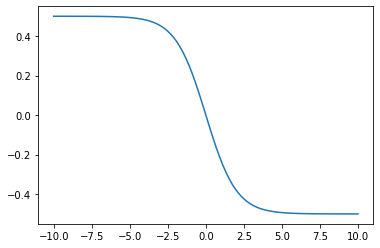

In [3]:
# 適当な関数に近いと報酬が大きくなるよにする
def func(x):
  return 1/(1+np.exp(x))-0.5

def reward(x, y):
  return np.exp( -( 5*((y-func(x)))**2 ) )

x_true = np.linspace( -10, 10, 100 )
y_true = func(x_true)

plt.plot( x_true, y_true, "-" )

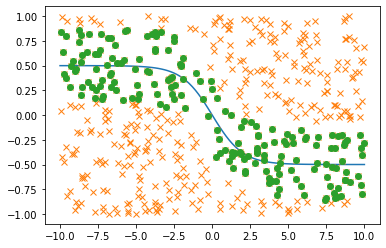

In [4]:
# ランダムに行動して報酬を計算
xt = (np.random.rand(500) -0.5) * 20
yt = (np.random.rand(500)-0.5) * 2
r = reward( xt, yt )

plt.plot( x_true, y_true, "-" )
plt.plot( xt, yt, "x" )
plt.plot( xt[r>0.5], yt[r>0.5], "o" )


tensor([729.9155], grad_fn=<AddBackward0>) tensor([-0.1000], requires_grad=True) tensor([-0.1000], requires_grad=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in sqrt


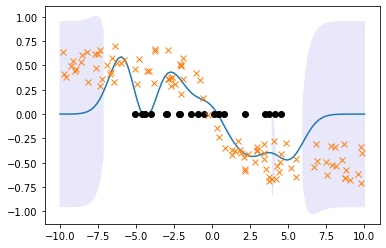

tensor([388.9228], grad_fn=<AddBackward0>) tensor([-2.0525], requires_grad=True) tensor([-3.5049], requires_grad=True)


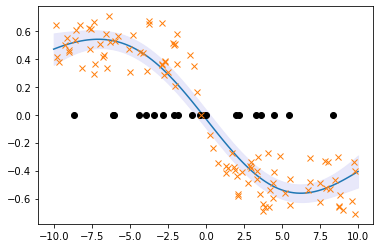

tensor([388.6491], grad_fn=<AddBackward0>) tensor([-1.7170], requires_grad=True) tensor([-3.6096], requires_grad=True)


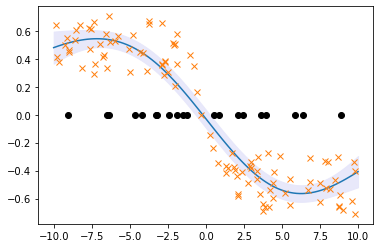

tensor([388.5795], grad_fn=<AddBackward0>) tensor([-1.6388], requires_grad=True) tensor([-3.6359], requires_grad=True)


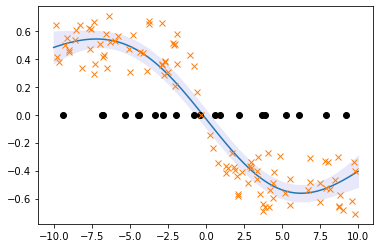

tensor([388.5374], grad_fn=<AddBackward0>) tensor([-1.6253], requires_grad=True) tensor([-3.6345], requires_grad=True)


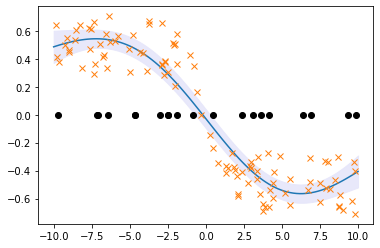

tensor([388.5280], grad_fn=<AddBackward0>) tensor([-1.6231], requires_grad=True) tensor([-3.6340], requires_grad=True)


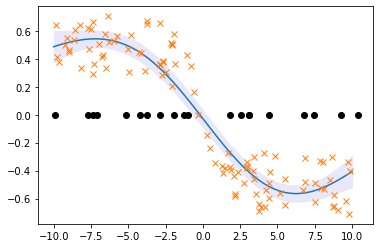

tensor([388.5160], grad_fn=<AddBackward0>) tensor([-1.6230], requires_grad=True) tensor([-3.6331], requires_grad=True)


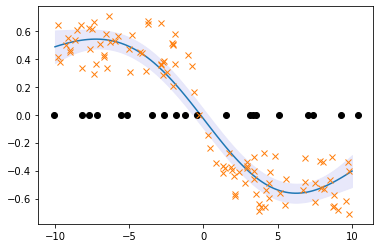

tensor([388.5155], grad_fn=<AddBackward0>) tensor([-1.6218], requires_grad=True) tensor([-3.6319], requires_grad=True)


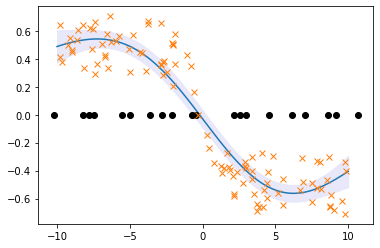

tensor([388.5150], grad_fn=<AddBackward0>) tensor([-1.6216], requires_grad=True) tensor([-3.6317], requires_grad=True)


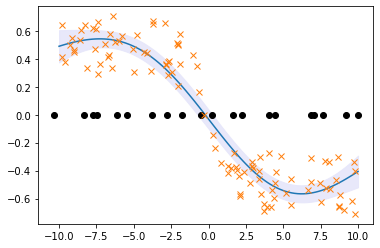

tensor([388.5130], grad_fn=<AddBackward0>) tensor([-1.6207], requires_grad=True) tensor([-3.6334], requires_grad=True)


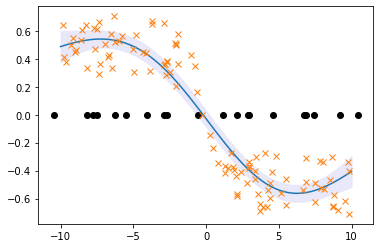

In [7]:
# GPを学習
gp = VBGP_PS( 20, 1, "cuda" )
gp.learn( xt.reshape((-1,1)), yt, r )